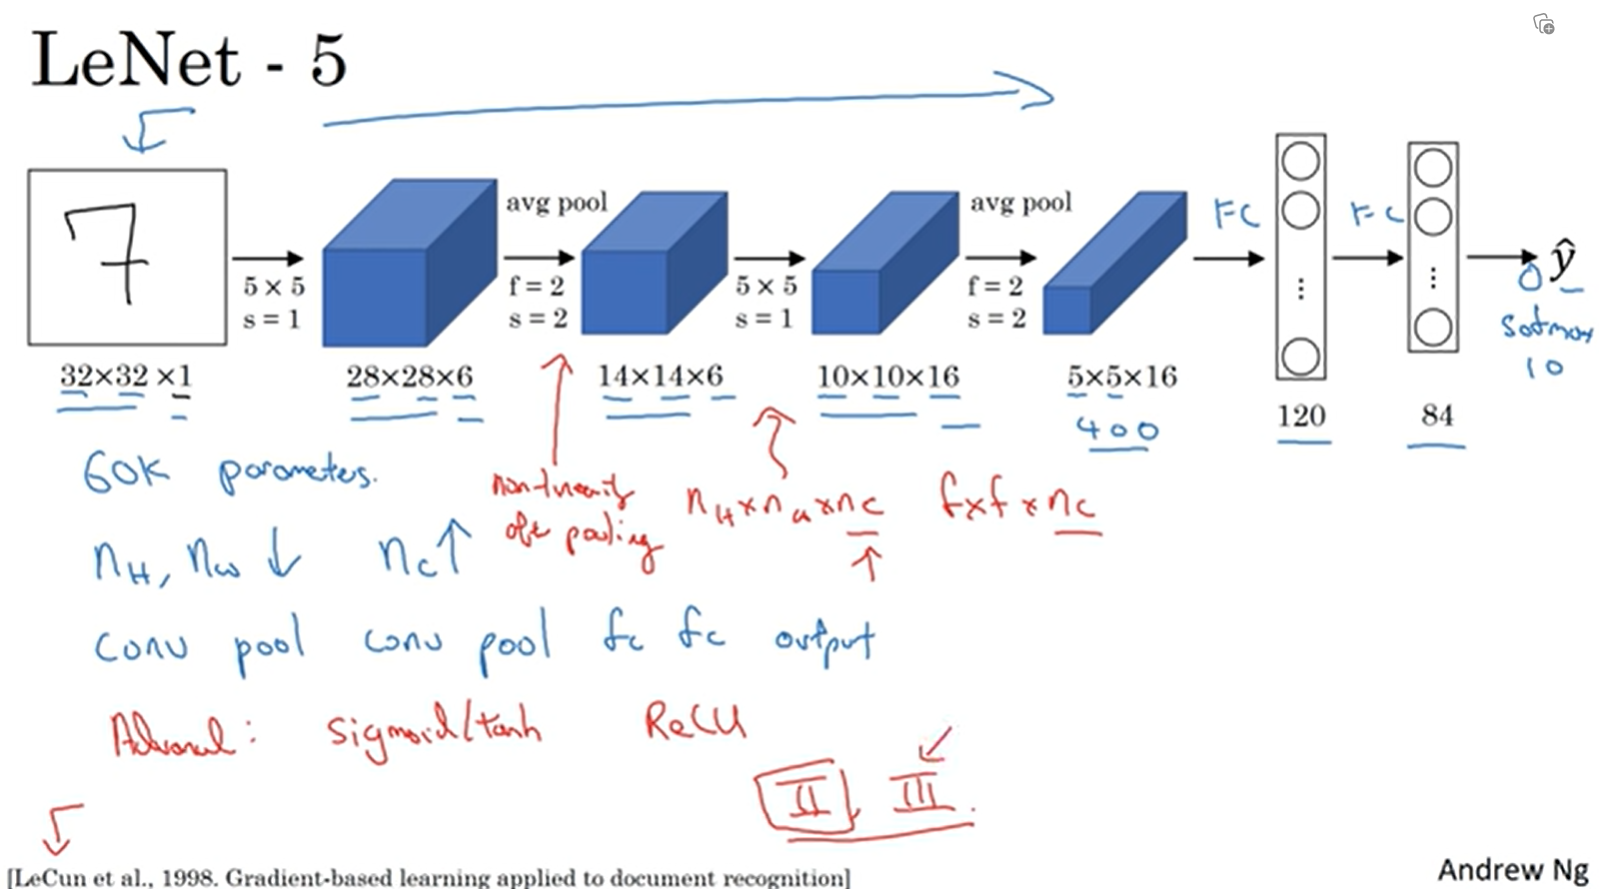

In [4]:
import os
import time
import torch
import torchvision
from torch import nn, optim
import argparse
import sys
sys.path.append("..") 
import mlutils.pytorch as mlutils

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        # input shape: 1 * 28 * 28
        self.conv = nn.Sequential(
            # conv layer 1
            # add padding: 28 * 28 -> 32 * 32
            # conv: 1 * 32 * 32 -> 6 * 28 * 28
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2), nn.Sigmoid(),
            # 6 * 28 * 28 -> 6 * 14 * 14
            nn.MaxPool2d(kernel_size=2, stride=2), # kernel_size, stride
            # conv layer 2
            # 6 * 14 * 14 -> 16 * 10 * 10 
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), nn.Sigmoid(),
            # 16 * 10 * 10 -> 16 * 5 * 5
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Sequential(
            # full connect layer 1
            nn.Linear(in_features=16 * 5 * 5, out_features=120), nn.Sigmoid(),
            # full connect layer 2
            nn.Linear(in_features=120, out_features=84), nn.Sigmoid(),
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

# save to mlutils so that other program can use it
def load_data_fashion_mnist(batch_size, resize=None, root='~/Datasets/FashionMNIST'):
    """Use torchvision.datasets module to download the fashion mnist dataset and then load into memory."""
    trans = []
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize))
    trans.append(torchvision.transforms.ToTensor())
    
    transform = torchvision.transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True, download=True, transform=transform)
    mnist_test = torchvision.datasets.FashionMNIST(root=root, train=False, download=True, transform=transform)
    if sys.platform.startswith('win'):
        num_workers = 0  
    else:
        num_workers = 4
    train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_iter, test_iter

# save to mlutils so that other program can use it
def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def train(net, train_iter, test_iter, batch_size, optimizer, num_epochs, device=try_gpu()):
    net = net.to(device)
    print("training on", device)
    loss = torch.nn.CrossEntropyLoss()
    timer = mlutils.Timer()
    # in one epoch, it will iterate all training samples
    for epoch in range(num_epochs):
        # Accumulator has 3 parameters: (loss, train_acc, number_of_images_processed)
        metric = mlutils.Accumulator(3)
        # all training samples will be splited into batch_size
        for X, y in train_iter:
            timer.start()
            # set the network in training mode
            net.train()
            # move data to device (gpu)
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            with torch.no_grad():
                # all the following metrics will be accumulated into variable `metric`
                metric.add(l * X.shape[0], mlutils.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            # metric[0] = l * X.shape[0], metric[2] = X.shape[0]
            train_l = metric[0]/metric[2]
            # metric[1] = number of correct predictions, metric[2] = X.shape[0]
            train_acc = metric[1]/metric[2]
        test_acc = mlutils.evaluate_accuracy_gpu(net, test_iter)
        if epoch % 1 == 0:
            print(f'epoch {epoch + 1} : loss {train_l:.3f}, train acc {train_acc:.3f}, test acc {test_acc:.3f}')
    # after training, calculate images/sec
    # variable `metric` is defined in for loop, but in Python it can be referenced after for loop
    print(f'total training time {timer.sum():.2f}, {metric[2] * num_epochs / timer.sum():.1f} images/sec ' f'on {str(device)}')



In [7]:
batch_size =128
net = LeNet()
num_epochs =10
lr = 0.001

optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# load data
train_iter, test_iter = mlutils.load_data_fashion_mnist(batch_size=batch_size)
# train
train(net, train_iter, test_iter, batch_size, optimizer, num_epochs)

training on cpu
epoch 1 : loss 1.384, train acc 0.491, test acc 0.681
epoch 2 : loss 0.722, train acc 0.728, test acc 0.754
epoch 3 : loss 0.593, train acc 0.771, test acc 0.782
epoch 4 : loss 0.526, train acc 0.800, test acc 0.806
epoch 5 : loss 0.482, train acc 0.821, test acc 0.819
epoch 6 : loss 0.449, train acc 0.834, test acc 0.825
epoch 7 : loss 0.426, train acc 0.843, test acc 0.830
epoch 8 : loss 0.407, train acc 0.851, test acc 0.838
epoch 9 : loss 0.391, train acc 0.857, test acc 0.848
epoch 10 : loss 0.377, train acc 0.861, test acc 0.841
total training time 105.17, 5704.8 images/sec on cpu
